In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
(digit_x_train, digit_y_train), (digit_x_test, digit_y_test) = tf.keras.datasets.mnist.load_data()
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = tf.keras.datasets.fashion_mnist.load_data()

digit_x_test = digit_x_test.reshape((-1, 28, 28, 1))
fashion_x_test = fashion_x_test.reshape((-1, 28, 28, 1))

train_x = train_x.astype('float32')/255
test_x = test_x.astype('float32')/255

digit_x_test = tf.image.resize(tf.image.grayscale_to_rgb(tf.Variable(digit_x_test)), (32, 32))
fashion_x_test = tf.image.resize(tf.image.grayscale_to_rgb(tf.Variable(fashion_x_test)), (32, 32))

Metal device set to: Apple M1


2021-11-01 16:57:56.019756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-01 16:57:56.019852: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
input_layer = tf.keras.layers.Input(train_x.shape[1:])

main_x = tf.keras.layers.Conv2D(
    32,
    3,
    activation = 'relu',
    padding = 'same'
)(input_layer)

main_x = tf.keras.layers.Conv2D(
    32,
    3,
    activation = 'relu',
    padding = 'same'
)(main_x)

main_x = tf.keras.layers.Conv2D(
    64,
    3,
    activation = 'relu',
    padding = 'same'
)(main_x)

main_x = tf.keras.layers.Conv2D(
    64,
    3,
    activation = 'relu',
    padding = 'same'
)(main_x)

main_x = tf.keras.layers.MaxPool2D(2)(main_x)

main_x = tf.keras.layers.Conv2D(
    128,
    3,
    activation = 'relu',
    padding = 'same'
)(main_x)

main_x = tf.keras.layers.Conv2D(
    128,
    3,
    activation = 'relu',
    padding = 'same'
)(main_x)

main_x = tf.keras.layers.MaxPool2D(2)(main_x)
main_x = tf.keras.layers.Flatten()(main_x)

main_x = tf.keras.layers.Dense(128, activation = 'relu')(main_x)
main_x = tf.keras.layers.Dense(128, activation = 'relu')(main_x)
main_output = tf.keras.layers.Dense(10, activation = 'softmax')(main_x)

ood_x = tf.keras.layers.Dense(128, activation = 'relu')(main_x)
ood_output = tf.keras.layers.Dense(32*32*3, activation = 'sigmoid')(ood_x)

model = tf.keras.models.Model(input_layer, [main_output, ood_output])
model.compile(
    loss = ['sparse_categorical_crossentropy', 'cosine_similarity'],
    optimizer = 'adam'
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   18496       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [4]:
x_train_output = (train_x).reshape((train_x.shape[0], -1))
x_test_output = (test_x).reshape((test_x.shape[0], -1))

digit_test_output = digit_x_test.numpy().reshape((digit_x_test.shape[0], -1))
fashion_test_output = fashion_x_test.numpy().reshape((digit_x_test.shape[0], -1))

model.fit(
    train_x,
    [train_y, x_train_output],
    validation_split = 0.2,
    epochs = 100,
    batch_size = 256,
    callbacks = [tf.keras.callbacks.EarlyStopping(min_delta = 0.03, patience = 3, restore_best_weights = True)]
)

2021-11-01 16:57:56.908165: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-01 16:57:56.909167: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100


2021-11-01 16:57:57.110802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - ETA: 0s - loss: 0.7690 - dense_2_loss: 1.6860 - dense_4_loss: -0.9170

2021-11-01 16:58:22.417341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 28s 174ms/step - loss: 0.7690 - dense_2_loss: 1.6860 - dense_4_loss: -0.9170 - val_loss: 0.4897 - val_dense_2_loss: 1.4165 - val_dense_4_loss: -0.9268
Epoch 2/100
157/157 [==============================] - 27s 170ms/step - loss: 0.3031 - dense_2_loss: 1.2327 - dense_4_loss: -0.9296 - val_loss: 0.2373 - val_dense_2_loss: 1.1687 - val_dense_4_loss: -0.9314
Epoch 3/100
157/157 [==============================] - 27s 170ms/step - loss: 0.0545 - dense_2_loss: 0.9867 - dense_4_loss: -0.9323 - val_loss: -0.0035 - val_dense_2_loss: 0.9315 - val_dense_4_loss: -0.9350
Epoch 4/100
157/157 [==============================] - 26s 167ms/step - loss: -0.1202 - dense_2_loss: 0.8141 - dense_4_loss: -0.9343 - val_loss: -0.0013 - val_dense_2_loss: 0.9335 - val_dense_4_loss: -0.9348
Epoch 5/100
157/157 [==============================] - 27s 171ms/step - loss: -0.2534 - dense_2_loss: 0.6827 - dense_4_loss: -0.9361 - val_loss: -0.1216 - val_dense_2_loss: 0.8168 - val

In [5]:
cifar_10_class_mapping = dict(zip(
    range(10), ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
))

In [6]:
preds, autoencode = model.predict(train_x)
preds = preds.argmax(axis = 1)
preds = [cifar_10_class_mapping[pred] for pred in preds]
similarities = tf.keras.losses.cosine_similarity(x_train_output.astype('float32'), autoencode.astype('float32')).numpy()
print(similarities.mean())
print(similarities.std())

threshold = similarities.mean() + 1.5*similarities.std()
print(threshold)

2021-11-01 17:01:56.620448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


-0.9380527
0.03908347
-0.8794275093823671


In [7]:
preds, autoencode = model.predict(test_x)
preds = preds.argmax(axis = 1)
preds = [cifar_10_class_mapping[pred] for pred in preds]
similarities = tf.keras.losses.cosine_similarity(x_test_output.astype('float32'), autoencode.astype('float32')).numpy()
trust = similarities <= threshold

In [8]:
pd.Series(trust).value_counts()

True     9317
False     683
dtype: int64

In [9]:
print(classification_report([cifar_10_class_mapping[val] for val in test_y.flatten()], preds))

              precision    recall  f1-score   support

    airplane       0.75      0.82      0.78      1000
  automobile       0.87      0.85      0.86      1000
        bird       0.67      0.57      0.62      1000
         cat       0.57      0.58      0.57      1000
        deer       0.63      0.76      0.69      1000
         dog       0.64      0.65      0.65      1000
        frog       0.79      0.79      0.79      1000
       horse       0.83      0.74      0.78      1000
        ship       0.86      0.83      0.85      1000
       truck       0.83      0.84      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



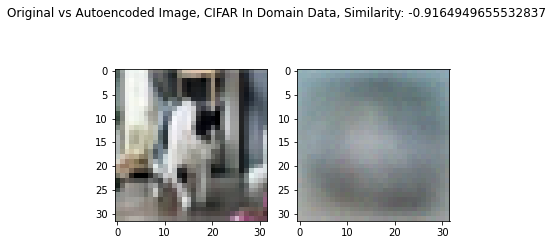

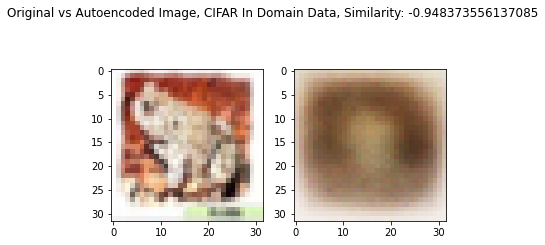

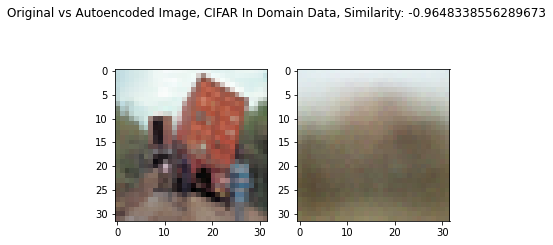

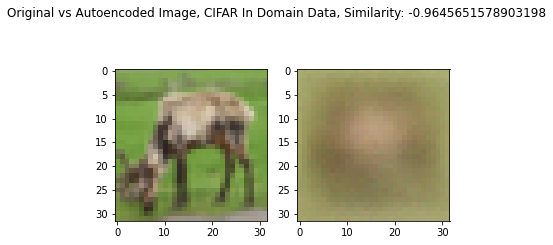

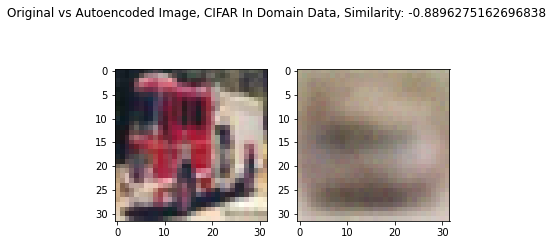

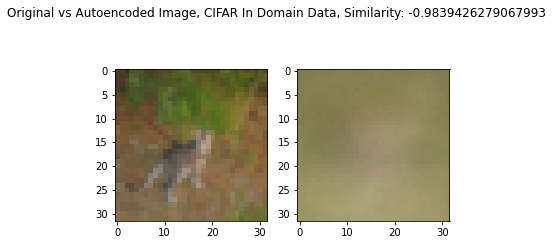

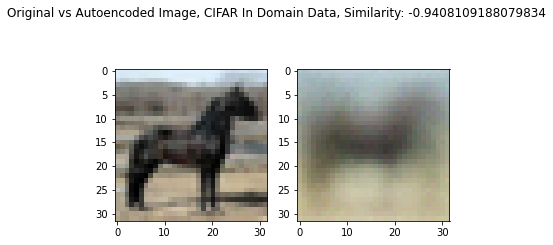

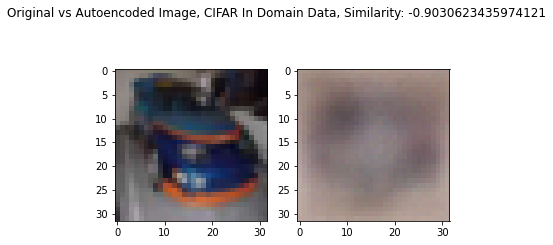

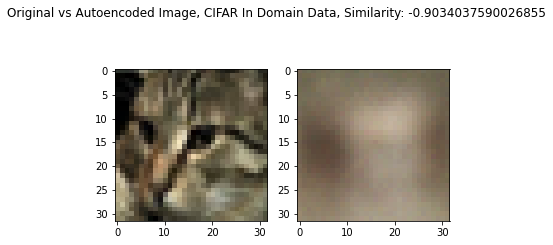

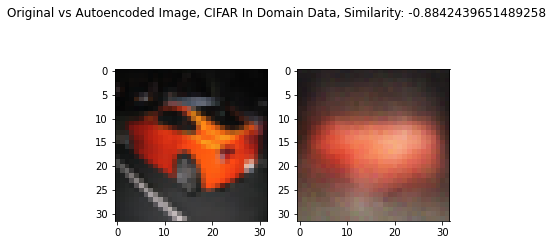

In [10]:
for random_index in np.random.choice(test_x.shape[0], 10, replace = False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.suptitle(f'Original vs Autoencoded Image, CIFAR In Domain Data, Similarity: {similarities[random_index]}')
    ax1.imshow(test_x[random_index])
    ax2.imshow(autoencode[random_index].reshape((32, 32, 3)))
    plt.show()

/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


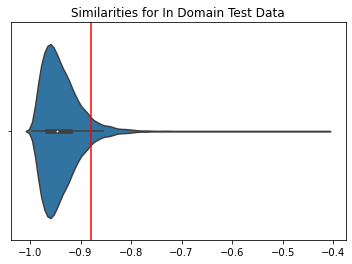

In [11]:
plt.Figure(figsize = (20, 8))
plt.title('Similarities for In Domain Test Data')
sns.violinplot(similarities)
plt.axvline(threshold, c = 'red')
plt.show()

In [12]:
digit_preds, digit_autoencode = model.predict(digit_x_test)
digit_preds = digit_preds.argmax(axis = 1)
digit_preds = [cifar_10_class_mapping[pred] for pred in digit_preds]
digit_similarities = tf.keras.losses.cosine_similarity(digit_test_output.astype('float32'), digit_autoencode.astype('float32')).numpy()
digit_trust = digit_similarities <= threshold
print(digit_similarities.mean())
print(digit_similarities.std())

-0.59761256
0.09487512


In [13]:
pd.Series(digit_trust).value_counts()

False    9996
True        4
dtype: int64

In [14]:
print(classification_report([cifar_10_class_mapping[val] for val in digit_y_test.flatten()], digit_preds))

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00       980
  automobile       0.02      0.01      0.01      1135
        bird       0.06      0.15      0.09      1032
         cat       0.01      0.01      0.01      1010
        deer       0.00      0.00      0.00       982
         dog       0.05      0.25      0.09       892
        frog       0.00      0.00      0.00       958
       horse       0.03      0.00      0.00      1028
        ship       0.06      0.08      0.07       974
       truck       0.00      0.00      0.00      1009

    accuracy                           0.05     10000
   macro avg       0.02      0.05      0.03     10000
weighted avg       0.02      0.05      0.03     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


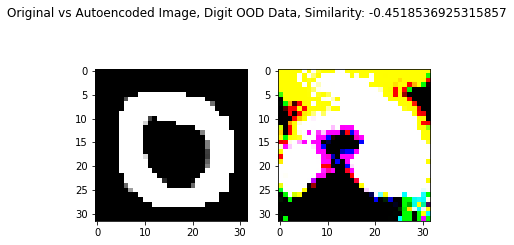

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


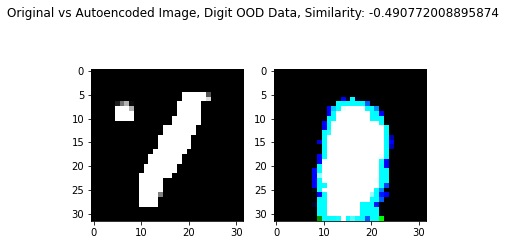

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


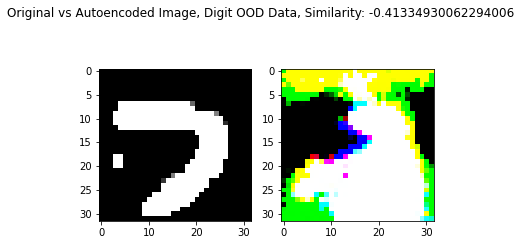

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


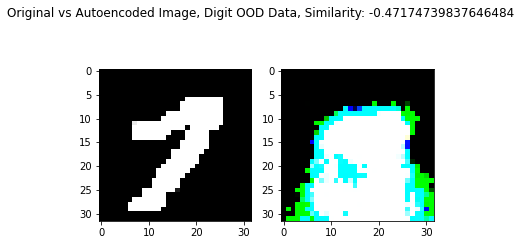

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


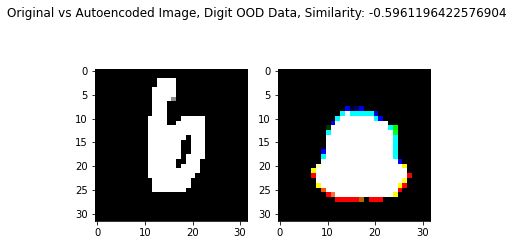

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


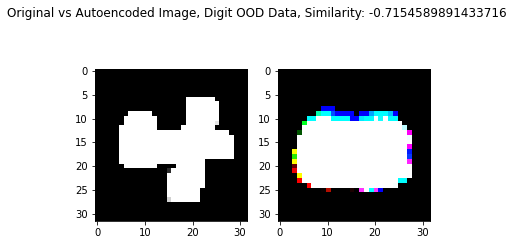

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


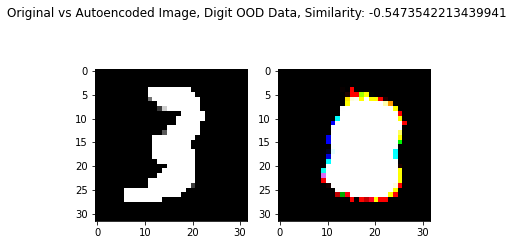

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


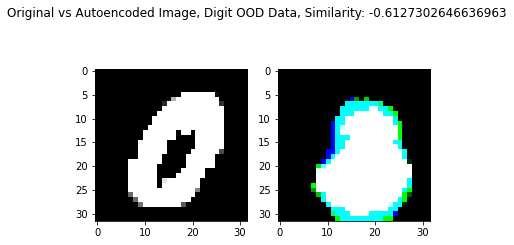

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


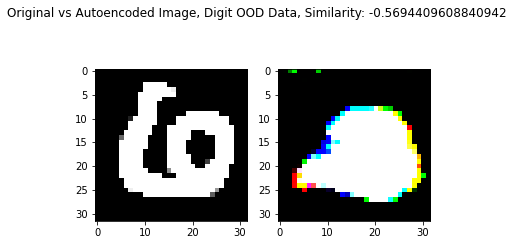

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


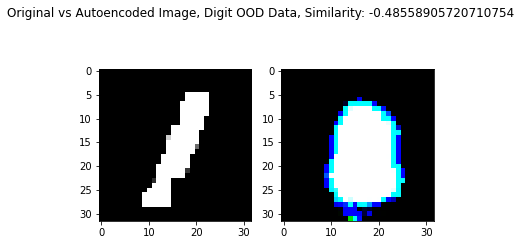

In [15]:
for random_index in np.random.choice(digit_x_test.shape[0], 10, replace = False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.suptitle(f'Original vs Autoencoded Image, Digit OOD Data, Similarity: {digit_similarities[random_index]}')
    ax1.imshow(digit_x_test[random_index])
    ax2.imshow(digit_autoencode[random_index].reshape((32, 32, 3)))
    plt.show()

/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


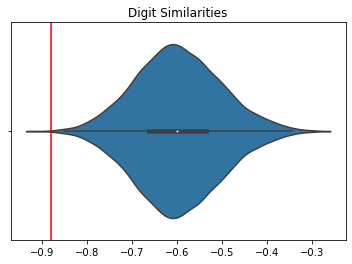

In [16]:
plt.Figure(figsize = (20, 8))
plt.title('Digit Similarities')
sns.violinplot(digit_similarities)
plt.axvline(threshold, c = 'red')
plt.show()

In [17]:
fashion_preds, fashion_autoencode = model.predict(fashion_x_test)
fashion_preds = fashion_preds.argmax(axis = 1)
fashion_preds = [cifar_10_class_mapping[pred] for pred in fashion_preds]
fashion_similarities = tf.keras.losses.cosine_similarity(fashion_test_output.astype('float32'), fashion_autoencode.astype('float32')).numpy()
fashion_trust = fashion_similarities <= threshold
print(fashion_similarities.mean())
print(fashion_similarities.std())

-0.79730517
0.08872931


In [18]:
pd.Series(fashion_trust).value_counts()

False    8586
True     1414
dtype: int64

In [19]:
print(classification_report([cifar_10_class_mapping[val] for val in digit_y_test.flatten()], digit_preds))

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00       980
  automobile       0.02      0.01      0.01      1135
        bird       0.06      0.15      0.09      1032
         cat       0.01      0.01      0.01      1010
        deer       0.00      0.00      0.00       982
         dog       0.05      0.25      0.09       892
        frog       0.00      0.00      0.00       958
       horse       0.03      0.00      0.00      1028
        ship       0.06      0.08      0.07       974
       truck       0.00      0.00      0.00      1009

    accuracy                           0.05     10000
   macro avg       0.02      0.05      0.03     10000
weighted avg       0.02      0.05      0.03     10000



/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


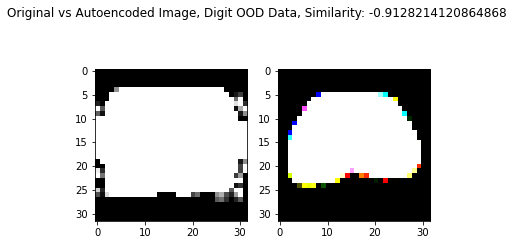

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


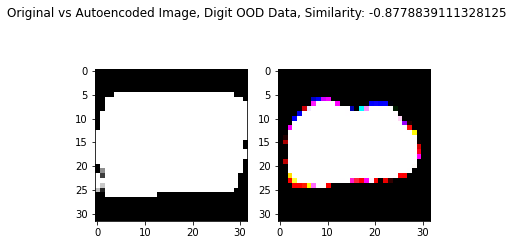

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


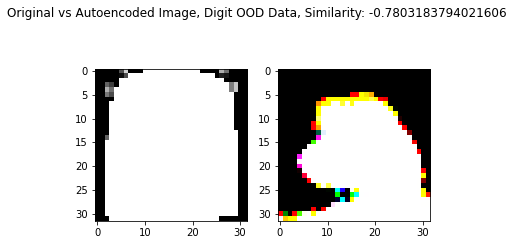

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


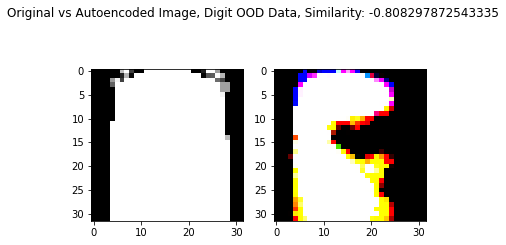

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


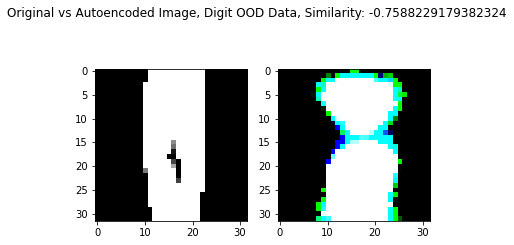

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


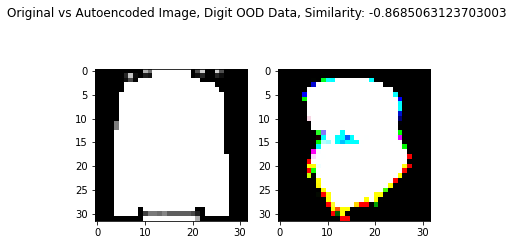

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


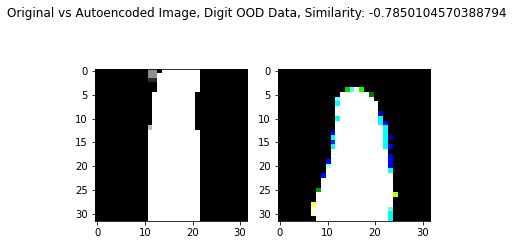

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


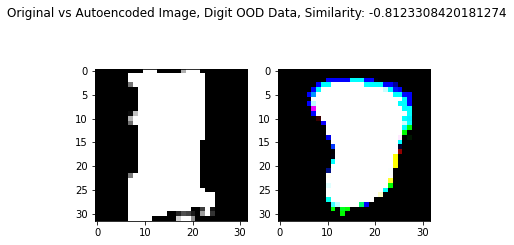

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


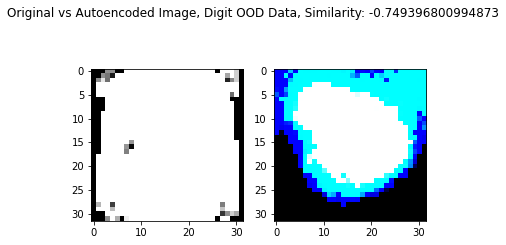

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


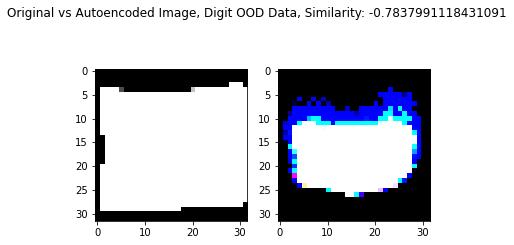

In [20]:
for random_index in np.random.choice(fashion_x_test.shape[0], 10, replace = False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.suptitle(f'Original vs Autoencoded Image, Digit OOD Data, Similarity: {fashion_similarities[random_index]}')
    ax1.imshow(fashion_x_test[random_index])
    ax2.imshow(fashion_autoencode[random_index].reshape((32, 32, 3)))
    plt.show()

/Users/jwrenn4/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


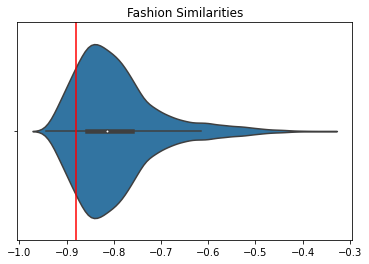

In [22]:
plt.Figure(figsize = (20, 8))
plt.title('Fashion Similarities')
sns.violinplot(fashion_similarities)
plt.axvline(threshold, c = 'red')
plt.show()